In [2]:
# Data manipulation
import pandas as pd
import numpy as np

In [3]:
import time
import datetime
import os
from tqdm import tqdm
import json

In [4]:
# Parsing and pre-processing
import os
import re

from langdetect import detect, DetectorFactory

In [6]:
df = pd.read_json(r"../../../../data/processed/data_merged_2023_03_08.json")

### I. Clean Simplified Text and Create sec_text

In [10]:
import re

def _parse_simplified_text2(text):
    # Define the start and end patterns
    start_pattern = re.compile(r'(?i)business activities of the undertakings concerned are|business activities')
    end_pattern = re.compile(r'(?i)after examination of the notification|\n \n|\n\n')

    result = "None"
    try:
        # Find the start and end positions of the patterns
        start_pos = start_pattern.search(text).end()
        end_match = end_pattern.search(text[start_pos:])
        if end_match is None:
            end_pos = len(text)
        else:
            end_pos = start_pos + end_match.start()

        # Extract the text between the patterns
        result = text[start_pos:end_pos].strip()
    except AttributeError:
        pass
    except UnboundLocalError:
        pass

    return result


In [11]:
# Simplified: parse again business activities
df.loc[df['section_text'] == "None", "section_text"] = df.loc[df['section_text'] == "None", "bsn_act"].apply(_parse_simplified_text2)

In [12]:
# Simplified: change section_text to simp_text where len_pdf <= 5 or section == "None"
df.loc[df["len_pdf"] <= 5, "section_text"] = df.loc[df["len_pdf"] <= 5, "simp_text"]

In [13]:
# Simplified: change sec_text to simp_text where len_pdf <= 5 or section == "None"
df.loc[df["len_pdf"] <= 5, "sec_text"] = df.loc[df["len_pdf"] <= 5, "simp_text"]

In [14]:
# Non-Simplified: Join the texts in 'section_text' using '\n' as the separator
df.loc[df["len_pdf"] > 5, 'sec_text'] = df.loc[df["len_pdf"] > 5, 'section_text'].apply(lambda lst: '\n'.join(lst))

In [15]:
df = df.reset_index(drop=True)

In [16]:
len(df[df['section_text'] == "None"])

109

In [17]:
len(df[df['sec_text'] == ""])

0

#### Drop if section_text is "None" or sec_text is ""

In [18]:
# Drop if section_text is "None"
df = df[df['section_text'] != "None"].reset_index(drop=True)

In [19]:
# Drop if sec_text is ""
df = df[df['sec_text'] != ""].reset_index(drop=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15694 entries, 0 to 15693
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          15694 non-null  object 
 1   year          15601 non-null  float64
 2   len_pdf       15694 non-null  int64  
 3   article       15694 non-null  object 
 4   article_txt   15694 non-null  object 
 5   article_62    15694 non-null  object 
 6   article_new   15694 non-null  object 
 7   case_num      15694 non-null  object 
 8   filename      15694 non-null  object 
 9   file          15694 non-null  object 
 10  section_text  15694 non-null  object 
 11  bsn_act       15694 non-null  object 
 12  simp_text     15694 non-null  object 
 13  section       12236 non-null  object 
 14  sec_text      15694 non-null  object 
dtypes: float64(1), int64(1), object(13)
memory usage: 1.8+ MB


In [21]:
df[df['bsn_act']!=""]['sec_text']

0        : \n  for SL04: a private equity firm indirec...
1        : \n  for K+N: a globally active logistics co...
7        : \n−  for  BANKIA:  financial  services  and ...
8        : \n  for  KKR  :  investment  firm  that  pr...
9        : \n  Whirlpool  is  active  in  the  manufac...
                               ...                        
15240    : \n  for  Cordes  &  Graefe:  wholesale  and...
15310    : \n  for Onex: a private equity firm control...
15340    : \n  REWE is mainly active in the retail dis...
15478    : \n– for Cargill: the international  producti...
15504    : \n  for AMC: AMC is active in cinema exhibi...
Name: sec_text, Length: 3458, dtype: object

In [22]:
len(df[df['bsn_act']!=""]['sec_text'])

3458

In [23]:
# no. of cases under Simplified Procedure
df[df['bsn_act']!=""]['case_num'].nunique()

3438

### II. Add length of sec_text

In [24]:
df['count'] = df['sec_text'].str.split().apply(len)

<AxesSubplot: >

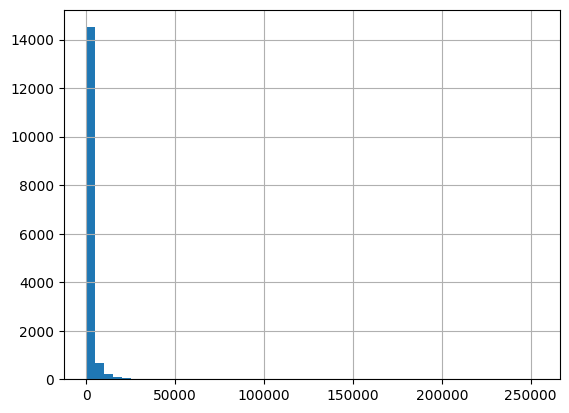

In [25]:
pd.Series(df['count']).hist(bins = 50)

In [26]:
len(df[df['count']<=2500])

13543

In [27]:
df[df['count']<50]['sec_text']

8        : \n  for  KKR  :  investment  firm  that  pr...
10       : \n–  for GIC: GIC is the holding company for...
11       : \n–  MAGNA is an automotive supplier which m...
13       (6)  Pursuant to an agreement and plan of merg...
18       : \n  Huaxin is a wholly PRC State-owned indu...
                               ...                        
15590    38.  For the above mentioned reasons, the Comm...
15598    (1258)  The Commission concludes that it is li...
15660    29.  For the above mentioned reasons, the Comm...
15665    26.  For the above mentioned reasons, the Comm...
15681    (25)  For the above mentioned reasons, the Com...
Name: sec_text, Length: 1478, dtype: object

#### Drop count with sec_text <=20

In [28]:
df = df[df['count']>20].reset_index(drop=True)

### III. Drop duplicates based on file and sec_text

In [29]:
df.drop_duplicates(subset=['file', 'sec_text'], keep='first', inplace=True)

df=df.reset_index(drop=True)

### IV. Rename Articles

In [30]:
df['article'] = df['article'].replace('art6.1', 'article6(2)')
df['article'] = df['article'].replace('art6.0', 'article6(1)(b)')
df['article'] = df['article'].replace('art8.1', 'article8(1)')
df['article'] = df['article'].replace('art8.2', 'article8(2)')
df['article'] = df['article'].replace('art8.3', 'article8(3)')
df['article'] = df['article'].replace('art9.3', 'referral')

In [31]:
# no. of cases by article_txt
df.groupby('article_txt')['case_num'].nunique().sort_index()

article_txt
None                83
article17(2)         8
article21            1
article22            4
article22(1)         1
article22(3)        13
article232           1
article4(4)         12
article6(1)          9
article6(1)(a)       1
article6(1)(b)    4657
article6(2)         55
article6(4)          1
article7(3)         28
article8(1)         33
article8(2)         63
article8(3)         10
article8(4)          1
article9             3
article9(2)          1
article9(3)         24
article9(3)(b)       2
Name: case_num, dtype: int64

In [32]:
# change 6(1) to 6.2
df['article_txt'] = df['article_txt'].replace("article6(1)", "article6(2)") 

In [33]:
df['article_62'].value_counts()

None                            13273
inconjunctionwithart6(2)         1225
inconjunctionwitharticle6(2)      120
Name: article_62, dtype: int64

In [34]:
# change to 6.2 with in conjunction
df['article_txt'] = np.where(df['article_62'].isin(['inconjunctionwitharticle6(2)', 'inconjunctionwithart6(2)']), 'article6(2)', df['article_txt'])

#### Clean article_new

In [35]:
# referral
mask = (df['article_txt'].isin(["article4(4)", "article22(3)", "article22", "article9(3)", "article9(3)(b)", "article9", "article9(2)"]))

In [36]:
# article_new
df['article_new'] = np.where(mask, 'referral', df['article_txt'])

In [37]:
# refusal - Article 7.3
mask73 = (df['article_txt'].isin(["article7(3)"]))
df['article_new'] = np.where(mask73, 'article7(3)', df['article_new'])

In [38]:
# no. of cases by article_new
df.groupby('article_new')['case_num'].nunique().sort_index()

article_new
None                83
article17(2)         8
article21            1
article22(1)         1
article232           1
article6(1)(a)       1
article6(1)(b)    4505
article6(2)        214
article6(4)          1
article7(3)         28
article8(1)         33
article8(2)         63
article8(3)         10
article8(4)          1
referral            59
Name: case_num, dtype: int64

### V. Subset based on articles

#### Subset only "article6(1)(b)", "article6(2)", "article8(1)", "article8(2)", "article8(3)", "referral", "article7(3)"

In [39]:
# subset based on article_new (only main articles)
df1 = df[df['article_new'].isin(["article6(1)(b)", "article6(2)", "article8(1)", "article8(2)", "article8(3)", "referral", "article7(3)"])]

#### Replace Simplified Procedure

In [40]:
df1.loc[df1['len_pdf'] <= 5, 'article_new'] = 'simplified'

In [41]:
len(df1[df1['len_pdf']<=5]['sec_text'])

3220

In [42]:
# no of cases by article_new
df1.groupby('article_new')['case_num'].nunique()

article_new
article6(1)(b)    1285
article6(2)        214
article7(3)         28
article8(1)         33
article8(2)         63
article8(3)         10
referral            59
simplified        3220
Name: case_num, dtype: int64

In [43]:
# no of documents by article_new
df1.groupby('article_new')['file'].nunique()

article_new
article6(1)(b)    1287
article6(2)        218
article7(3)         29
article8(1)         33
article8(2)         64
article8(3)         10
referral            92
simplified        3220
Name: file, dtype: int64

### VI. Detect English sec_text and subset to English merger decisions

In [44]:
df1["lang"] = df1["sec_text"].apply(lambda x: detect(x) if x is not None else None)

C:\Users\admin\AppData\Local\Temp\ipykernel_10320\2238364212.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["lang"] = df1["sec_text"].apply(lambda x: detect(x) if x is not None else None)


In [45]:
len(df1.index)

14107

In [46]:
df1['lang'].value_counts()

en    14094
fr       10
no        1
de        1
id        1
Name: lang, dtype: int64

#### Drop non-English

In [47]:
df_eng = df1[df1['lang']=="en"]
df_eng = df_eng.reset_index(drop=True)

In [48]:
len(df_eng.index)

14094

In [49]:
df_eng.groupby('article_new')['file'].nunique()

article_new
article6(1)(b)    1287
article6(2)        218
article7(3)         29
article8(1)         33
article8(2)         64
article8(3)         10
referral            92
simplified        3210
Name: file, dtype: int64

### VII. Clean Section headings

#### Save headings to excel file

In [50]:
df_eng['section2'] = df_eng['section'].str.findall(r'\b[A-Z\s]+\b').str.join(' ').str.strip()

In [51]:
headings = df_eng['section'].value_counts()

In [52]:
headings2 = pd.DataFrame(df_eng['section2'].value_counts()).reset_index()
headings2.columns = ['section', 'count']
headings2 = headings2.explode('section')

In [53]:
headings2.to_excel('D:\Desktop\Thesis\predicting-merger-decision-outcomes\output\headings.xlsx')

In [54]:
headings2.head(10)

,section,count
0,CONCLUSION,730
1,COMPETITIVE ASSESSMENT,557
2,I THE PARTIES,547
3,THE PARTIES,497
4,EU DIMENSION,436
5,VI CONCLUSION,380
6,V COMPETITIVE ASSESSMENT,321
7,II THE OPERATION,275
8,RELEVANT MARKETS,251
9,III COMMUNITY DIMENSION,251


#### Rename Sections into 7 general subheadings

In [55]:
df_eng['section_fin'] = ""

DROP subheadings

In [56]:
df_eng['section_fin'] = np.where((df_eng['section2']==""), 'DROP', df_eng['section_fin'])

In [57]:
len(df_eng[df_eng['section_fin']=="DROP"])

15

1. Introduction, Background, Summary

In [58]:
mask_intro = df_eng['section2'].str.lower().str.contains('introduction|summary|background')

In [59]:
df_eng['section_fin'] = np.where(mask_intro, 'Introduction/ Summary', "")

2. Parties, Operation, Transaction

In [60]:
mask_party = df_eng['section2'].str.lower().str.contains('parties|operation|transaction|joint venture')

In [61]:
df_eng['section_fin'] = np.where(mask_party, 'Parties & Operation', df_eng['section_fin'])

3. Concentration & Dimension

In [62]:
mask_dim = df_eng['section2'].str.lower().str.contains('concentration|dimension|community dimmension|jurisdiction of the commission')

In [63]:
df_eng['section_fin'] = np.where(mask_dim, 'Concentration & Dimension', df_eng['section_fin'])

4. Market Definition

In [64]:
mask_market = df_eng['section2'].str.lower().str.contains('relevant market|product|geographic|industry|market definition|marketdefinition|marketdefinitions|market|\
                definition|definitions|united kingdom|germany|slovakia|hungary|czechia|london|\
                applicability of the eea agreement|wholesale|retail|telecommunications sector|upstream|downstream|\
                cargo transport and freight forwarding|\
                cementitious materials|fluid catalytic cracking fcc trains|adgt  driven|adgt|steam turbines|greycement|high and very high speedbananas|\
                bananas|\
                bagged salad|\
                london heathrow|\
                iv away from home|\
                iv cell culture|\
                iv parent reels|\
                iv laboratory chemicals|\
                iv vaccines|\
                v smoking cessation|\
                v cold sore management|\
                v cold and flu treatments|\
                v allergic rhinitis treatments|\
                v pain management|\
                v gastrointestinal treatments|\
                v antifungals|\
                iv targeted therapies|\
                v chemotherapies|\
                batteries|\
                iv analgesics|\
                iv throat preparations|\
                iv antipruritics|\
                v analgesics|\
                v throat preparations|\
                v antipruritics|\
                iv biosimilars|\
                iv other molecules|\
                resins')

In [65]:
df_eng['section_fin'] = np.where(mask_market, 'Market Definition', df_eng['section_fin'])

5. Competitive Assessment

In [66]:
mask_assess = df_eng['section2'].str.lower().str.contains('competitive assessment|analysis|analyses|assessment|investigation|\
            effect|horizontal|vertical|conglomerate|coordinated|foreclosure|nash|bertrand|data|robustness tests|methodology|method|efficiencies|\
            competitive assesment|competitiveassesment|competitiveasessment|competitive asessment|share|competitive  structure|merger simulation|simulation|\
            recent studies|overview of the commission s approach|cashinstruments|\
            appendix')

In [67]:
df_eng['section_fin'] = np.where(mask_assess, 'Competitive Assessment', df_eng['section_fin'])

6. Conclusion

In [68]:
mask_conclusion = df_eng['section2'].str.lower().str.contains('conclusion')

In [69]:
df_eng['section_fin'] = np.where(mask_conclusion, 'Conclusion', df_eng['section_fin'])

7. Conditions for Art 6.2 and 8.2, 8.3 only

In [70]:
mask_commit = df_eng['section2'].str.lower().str.contains('commitment|remedies|remedy|obligation|condition|general provisions|slots|fare combinability')

In [71]:
df_eng['section_fin'] = np.where(df_eng['article_new'].isin(['article6(2)','article8(2)', 'article8(3)']) & mask_commit, 'Conditions', df_eng['section_fin'])

In [72]:
df_eng[df_eng['section_fin']=="Conditions"].article_new.value_counts()

article6(2)    356
article8(2)     92
article8(3)      8
Name: article_new, dtype: int64

8. Decision

In [73]:
mask_decision = df_eng['section2'].str.lower().str.contains('facts|fact|procedure|procedures|decision')

In [74]:
df_eng['section_fin'] = np.where(mask_decision, 'Decision', df_eng['section_fin'])

9. Requests

In [75]:
mask_req = df_eng['section2'].str.lower().str.contains('request|requests|referral|review clause')

In [76]:
df_eng['section_fin'] = np.where(mask_req, 'Request', df_eng['section_fin'])

10. Monitoring Trustee

In [77]:
mask_monitor = df_eng['section2'].str.lower().str.contains('monitor|monitoring|termination mandate|relationship with state aid rules|termination of mandate')

In [78]:
df_eng['section_fin'] = np.where(mask_monitor, 'Monitoring', df_eng['section_fin'])

11. None for Simplified Procedure

In [79]:
df_eng.loc[df_eng['len_pdf'] <= 5, 'section_fin'] = 'simplified'

12. For remaining Art 6.2 and 8.2 - Conditions - DONT RUN

In [80]:
df_eng[df_eng['section_fin']==""]['article_new'].value_counts()

article6(2)       194
article8(2)       139
article6(1)(b)    109
article7(3)        70
referral           22
article8(3)        19
article8(1)         5
Name: article_new, dtype: int64

In [81]:
# headings3 = pd.DataFrame(df_eng[(df_eng['section_fin']=="") & (df_eng['article_new'].isin(['article6(2)','article8(2)']))]['section2'].value_counts()).reset_index()
# headings3.columns = ['section', 'count']
# headings3 = headings3.explode('section')

# headings3.to_excel('D:\Desktop\Thesis\predicting-merger-decision-outcomes\output\headings_filtered.xlsx')

In [82]:
# df_eng[df_eng['section2']=="TERMINATION OF MANDATE"][['sec_text','article_new']]


In [83]:
# print(df_eng['section_fin'][10895])

In [84]:
# df_eng.loc[(df_eng['article_new'].isin(["article6(2)", "article8(2)"]) & (df_eng['section_fin']=="")), 'section_fin'] = 'Conditions'

13. For remaining Art 6.1(b) and 8.3, Art 6.2 and 8.2 - Competitive Assessment

In [85]:
df_eng.loc[((df_eng['article_new'].isin(["article6(1)(b)","article8(3)","article6(2)","article8(2)"])) & (df_eng['section_fin']=="")), 'section_fin'] = 'Competitive Assessment'

Others - 7.3 and Referral

In [86]:
df_eng.loc[((df_eng['article_new'].isin(["referral","article7(3)"])) & (df_eng['section_fin']=="")), 'section_fin'] = 'Others'

DROP subheadings

In [87]:
df_eng.loc[((df_eng['section_fin']=="") & (df_eng['section2']=="")), 'section_fin'] = 'DROP'

In [88]:
mask_drop = df_eng['section2'].str.lower().str.contains('comp m|cash instruments|derivatives')
df_eng['section_fin'] = np.where(mask_drop, 'DROP', df_eng['section_fin'])

In [89]:
# drop table of contents
# df_eng['section_fin'] = np.where(df_eng['sec_text'].str.contains('.........................'), 'DROP', df_eng['section_fin'])

In [90]:
df_eng['section_fin'].value_counts()

simplified                   3210
Concentration & Dimension    2609
Competitive Assessment       2259
Parties & Operation          2185
Conclusion                   1686
Market Definition            1069
Conditions                    456
Introduction/ Summary         170
DROP                          117
Request                       113
Decision                      106
Others                         83
Monitoring                     29
                                2
Name: section_fin, dtype: int64

#### Clean section further via sec_text

1. Introduction

In [91]:
mask_int = df_eng['sec_text'].str.contains('INTRODUCTION')

In [92]:
df_eng['section_fin'] = np.where(mask_int, 'Introduction/ Summary', df_eng['section_fin'])

2. Market Definition

In [93]:
mask_def = df_eng['sec_text'].str.contains('Market definition|Market definitions|Market Definition|Market Definitions|Relevant product market|Relevant geographic market|Relevant Product Market|Relevant Geographic Market|\
    RELEVANT PRODUCT MARKET|RELEVANT GEOGRAPHIC MARKET|RELEVANT MARKET|Relevant Market|Relevant market|Relevant markets')

In [94]:
df_eng['section_fin'] = np.where(mask_def, 'Market Definition', df_eng['section_fin'])

3. Competitive Assessment

In [95]:
mask_comp = df_eng['sec_text'].str.contains('Competitive Assessment|Competitive assessment|Competition analysis')

In [96]:
df_eng['section_fin'] = np.where(mask_comp, 'Competitive Assessment', df_eng['section_fin'])

In [97]:
df_eng['section_fin'].value_counts()

simplified                   3208
Concentration & Dimension    2598
Parties & Operation          2180
Competitive Assessment       2022
Conclusion                   1666
Market Definition            1345
Conditions                    444
Introduction/ Summary         195
DROP                          114
Request                       111
Decision                      104
Others                         78
Monitoring                     29
Name: section_fin, dtype: int64

4. Conclusion

In [98]:
# mask_conc = df_eng['sec_text'].str.contains('Conclusion')

In [99]:
# df_eng['section_fin'] = np.where(mask_conc, 'Conclus', df_eng['section_fin'])

5. Conditions - Art 6.2 and 8.2, 8.3

In [100]:
mask_cond = df_eng['sec_text'].str.contains('Remedies Notice|Commitments|Conditions')

In [101]:
df_eng['section_fin'] = np.where(df_eng['article_new'].isin(['article6(2)','article8(2)','article8(3)']) & mask_cond, 'Conditions', df_eng['section_fin'])

In [102]:
df_eng['section_fin'].value_counts().sort_index()

Competitive Assessment       1872
Concentration & Dimension    2596
Conclusion                   1448
Conditions                    947
DROP                          114
Decision                       77
Introduction/ Summary         184
Market Definition            1297
Monitoring                      5
Others                         78
Parties & Operation          2168
Request                       100
simplified                   3208
Name: section_fin, dtype: int64

Simplified

In [103]:
df_eng.loc[df_eng['len_pdf'] <= 5, 'section_fin'] = 'simplified'

In [104]:
# df_eng[df_eng['section_fin']=="Introduction/ Summary"][['sec_text','article_new', 'case_num']].tail(30)

In [105]:
# print(df_eng['sec_text'][13859])

In [106]:
df_eng[df_eng['section_fin']=="Conditions"]['article_new'].value_counts()

article6(2)    702
article8(2)    224
article8(3)     21
Name: article_new, dtype: int64

In [107]:
# no of cases by article_new
df_eng[df_eng['section_fin']=="Competitive Assessment"].groupby('article_new')['case_num'].nunique().sort_index()

article_new
article6(1)(b)    1100
article6(2)        157
article7(3)          2
article8(1)         17
article8(2)         49
article8(3)          9
referral            19
Name: case_num, dtype: int64

In [108]:
# save json file name
date = datetime.date.today().strftime('%Y_%m_%d')

file_name = f"../../../../data/processed/df_eng_cleaned_full_{date}.json"
if os.path.exists(file_name):
    os.remove(file_name)

# save file as json
df_eng.to_json(file_name)

### IX. Join by case_num and section

In [109]:
df_eng['section_fin'].value_counts()

simplified                   3210
Concentration & Dimension    2596
Parties & Operation          2168
Competitive Assessment       1872
Conclusion                   1448
Market Definition            1295
Conditions                    947
Introduction/ Summary         184
DROP                          114
Request                       100
Others                         78
Decision                       77
Monitoring                      5
Name: section_fin, dtype: int64

In [110]:
# df_eng['text_order'] = df_eng.groupby(['year', 'article_new', 'case_num', 'file', 'section_fin']).cumcount() + 1

In [111]:
# Group the dataframe by 'case_num', 'article_new', and 'section_fin', and join the 'sec_text' column
df_grouped = df_eng.groupby(['year', 'article_new', 'case_num', 'file', 'section_fin', 'len_pdf'])['sec_text'].agg(' '.join).reset_index()

In [112]:
# no of cases by article_new
df_grouped.groupby('article_new')['case_num'].nunique().sort_index()

article_new
article6(1)(b)    1285
article6(2)        212
article7(3)         28
article8(1)         33
article8(2)         63
article8(3)         10
referral            59
simplified        3194
Name: case_num, dtype: int64

In [113]:
df_grouped['section_fin'].value_counts()

simplified                   3194
Concentration & Dimension    1622
Parties & Operation          1558
Conclusion                   1439
Competitive Assessment       1356
Market Definition            1088
Conditions                    283
Introduction/ Summary         175
DROP                          114
Request                        96
Decision                       74
Others                         38
Monitoring                      5
Name: section_fin, dtype: int64

In [114]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11042 entries, 0 to 11041
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         11042 non-null  float64
 1   article_new  11042 non-null  object 
 2   case_num     11042 non-null  object 
 3   file         11042 non-null  object 
 4   section_fin  11042 non-null  object 
 5   len_pdf      11042 non-null  int64  
 6   sec_text     11042 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 604.0+ KB


In [115]:
# save json file name
date = datetime.date.today().strftime('%Y_%m_%d')

file_name = f"../../../../data/processed/df_eng_grouped_full_{date}.json"
if os.path.exists(file_name):
    os.remove(file_name)

# save file as json
df_grouped.to_json(file_name)

### VIII. Filter based on 'section'/subheading and article_new

In [116]:
df_eng_filtered = df_grouped[(~df_grouped['article_new'].isin(["article7(3)"]) & 
                          ~df_grouped['section_fin'].isin(["DROP", "Conclusion", "Decision",
                                                       "Conditions", "Request", "Monitoring",
                                                       "Introduction/ Summary", "Others"]))]

In [117]:
df_eng_filtered['section_fin'].value_counts()

simplified                   3194
Concentration & Dimension    1602
Parties & Operation          1532
Competitive Assessment       1354
Market Definition            1087
Name: section_fin, dtype: int64

In [118]:
df_eng_filtered['article_new'].value_counts()

article6(1)(b)    4415
simplified        3194
article6(2)        664
referral           204
article8(2)        170
article8(1)         94
article8(3)         28
Name: article_new, dtype: int64

In [119]:
# no. of cases by article_new
df_eng_filtered.groupby('article_new')['case_num'].nunique().sort_index()

article_new
article6(1)(b)    1284
article6(2)        201
article8(1)         32
article8(2)         57
article8(3)          9
referral            59
simplified        3194
Name: case_num, dtype: int64

In [120]:
df_eng_filtered[df_eng_filtered['article_new']=="article6(2)"]['section_fin'].value_counts()

Concentration & Dimension    195
Parties & Operation          180
Competitive Assessment       157
Market Definition            132
Name: section_fin, dtype: int64

In [121]:
# no. of cases by article_new
df_eng_filtered.groupby('article_new')['case_num'].nunique().sort_index()

article_new
article6(1)(b)    1284
article6(2)        201
article8(1)         32
article8(2)         57
article8(3)          9
referral            59
simplified        3194
Name: case_num, dtype: int64

In [122]:
df_eng_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8769 entries, 0 to 11041
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         8769 non-null   float64
 1   article_new  8769 non-null   object 
 2   case_num     8769 non-null   object 
 3   file         8769 non-null   object 
 4   section_fin  8769 non-null   object 
 5   len_pdf      8769 non-null   int64  
 6   sec_text     8769 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 548.1+ KB


### X. Drop unnecessary columns

In [123]:
df_eng_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8769 entries, 0 to 11041
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         8769 non-null   float64
 1   article_new  8769 non-null   object 
 2   case_num     8769 non-null   object 
 3   file         8769 non-null   object 
 4   section_fin  8769 non-null   object 
 5   len_pdf      8769 non-null   int64  
 6   sec_text     8769 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 548.1+ KB


In [124]:
# df_eng_filtered = df_eng_filtered.drop(columns=['date', 'article', 'article_txt', 'article_62', 'filename',
#                                                 'section_text', 'bsn_act', 'simp_text','section','section2'])

In [125]:
# save json file name
date = datetime.date.today().strftime('%Y_%m_%d')

file_name = f"../../../../data/processed/df_eng_clean_filtered_{date}.json"
if os.path.exists(file_name):
    os.remove(file_name)

# save file as json
df_eng_filtered.to_json(file_name)